In [15]:
#!pip install lightning

In [3]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, ProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

np.random.seed(seed=1)
L.seed_everything(seed=1, workers=True)

[rank: 0] Seed set to 1


1

#### Data Import

In [4]:
train = pl.read_csv(source='train_df.csv')
test = pl.read_csv(source='validation_df.csv')
test_label = pl.read_csv(source='dfvalid_groundtruth.csv')

In [5]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,…,61403,61404,61405,61406,61407,61408,61409,61410,61411,61412,61413,61414,61415,61416,61417,61418,61419,61420,61421,61422,61423,61424,61425,61426,61427,61428,61429,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.041259,0.041259,0.032573,0.023887,0.029315,0.041259,0.045602,0.038001,0.030401,0.032573,0.041259,0.046687,0.045602,0.040173,0.034744,0.034744,0.040173,0.042344,0.038001,0.030401,0.027144,0.027144,0.030401,0.030401,0.026058,0.029315,0.044516,0.049945,0.041259,0.034744,0.040173,0.045602,0.040173,0.032573,0.032573,0.036916,…,-0.022801,0.056459,0.11509,0.016286,-0.056459,0.015201,0.062974,-0.002172,-0.016286,0.04343,0.018458,-0.026058,0.034744,0.084689,0.039087,0.0,-0.010858,-0.038001,-0.018458,0.047773,0.047773,-0.024972,-0.020629,0.078174,0.093375,0.018458,0.013029,0.034744,-0.0076,-0.003257,0.065145,0.047773,-0.009772,0.031487,0.096632,0.077089,0.040173
1,-0.211722,-0.264924,-0.274696,-0.236694,-0.156349,-0.059716,0.005429,0.046687,0.153091,0.28121,0.31704,0.318126,0.356127,0.390871,0.386528,0.292068,0.13029,0.040173,0.024972,-0.052116,-0.169378,-0.219322,-0.219322,-0.23018,-0.267095,-0.312697,-0.310526,-0.26601,-0.235609,-0.172635,-0.038001,0.042344,0.066231,0.178064,0.31704,0.410415,…,0.640595,0.787171,1.016265,1.059696,0.850145,0.771971,0.750256,0.387614,-0.090118,-0.414758,-0.638423,-0.781743,-0.842545,-0.89249,-0.998893,-0.918548,-0.572192,-0.279039,-0.033658,0.205207,0.465788,0.847974,1.14547,1.13027,0.875117,0.701397,0.568935,0.260581,-0.004343,-0.241037,-0.636252,-0.953292,-0.980436,-0.846888,-0.838202,-0.880546,-0.739398
2,0.214105,0.15493,0.13664,0.013987,-0.038733,-0.015063,-0.111894,-0.104363,0.04734,-0.054871,-0.235623,-0.174296,-0.189359,-0.302329,-0.238851,-0.128033,-0.058099,0.034429,-0.00538,-0.078541,0.060251,0.117273,0.025822,0.078541,0.163537,0.146323,0.116198,0.051643,-0.013987,0.020442,0.011835,-0.0893,-0.043036,-0.046264,-0.242078,-0.247458,…,-0.94034,-1.264186,-1.320134,-1.127547,-1.00597,-0.762816,-0.193663,0.278659,0.539028,0.754208,1.037171,1.178114,1.178114,1.252352,1.164128,0.753132,0.313088,-0.094679,-0.383022,-0.710096,-1.136154,-1.333044,-1.24482,-1.058689,-0.930656,-0.731614,-0.318467,0.040884,0.37549,0.699337,0.965085,1.086662,1.132926,1.279249,1.296464,0.937112,0.451879
3,-0.154837,-0.127768,-0.217638,-0.28477,-0.299929,-0.270694,-0.07796,0.092036,0.076877,0.154837,0.296681,0.228466,0.165665,0.272859,0.31617,0.288018,0.258783,0.125602,0.011911,0.011911,-0.075794,-0.129933,-0.048725,-0.028152,-0.120188,-0.204645,-0.238211,-0.25337,-0.258783,-0.275025,-0.180824,0.051973,0.081208,0.018407,0.188403,0.294515,…,-0.264197,-0.110443,0.080125,0.036814,0.032483,-0.006497,-0.18732,-0.144009,0.120188,0.272859,0.140761,0.027069,-0.018407,-0.152671,-0.08987,0.098533,0.084457,-0.018407,-0.149423,-0.144009,-0.090953,-0.132099,-0.113691,0.001083,0.153754,0.085539,-0.205727,-0.286936,-0.171079,-0.036814,-0.024904,0.0314,0.140761,-0.011911,-0.173244,-0.063884,0.081208
4,-1.02278,-0.916376,-0.676425,-0.461445,-0.330069,-0.12269,0.178064,0.489675,0.799115,0.931577,0.938091,0.997808,0.948949,0.61888,0.212808,-0.015201,-0.221494,-0.485332,-0.559163,-0.577621,-0.740484,-0.867517,-0.857745,-0.771971,-0.616708,-0.264924,0.170463,0.450588,0.643852,0.766542,0.863174,1.044495,1.086839,0.746999,0.275781,0.041259,…,-0.413672,-0.023887,0.255152,0.498361,0.735055,0.740484,0.679682,0.826259,1.001065,0.916376,0.64168,0.31704,-0.077089,-0.425615,-0.689454,-0.840373,-0.815401,-0.774142,-0.783914,-0.648195,-0.331155,-0.046687,0.199779,0.449502,0.422358,0.258409,0.501618,1.009751,1.134613,0.83603,0.479903,0.109661,-0.2

#### Data Preprocessing
No further preprocessing was conducted, although it may be sensible when working with accelerator data [...].

In [6]:
scaler = MinMaxScaler()

train = scaler.fit_transform(train)
test = scaler.transform(test)

#### PyTorch Dataset Implementation

In [7]:
class SensorDataset(Dataset):

    def __init__(self, dataset: np.array):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return torch.FloatTensor(self.dataset[index])

#### PyTorch Progress Bar Implementation

In [8]:
class SimpleProgressBar(ProgressBar):
    def __init__(self):
        super().__init__()
        self.bar = None
        self.enabled = True

    def on_train_epoch_start(self, trainer, pl_module):
        if self.enabled:
            self.bar = tqdm(total=self.total_train_batches,
                            desc=f"Epoch {trainer.current_epoch+1}",
                            position=0,
                            leave=True)
            self.running_loss = 0.0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if self.bar:
            self.running_loss += outputs['loss'].item()
            self.bar.update(1)
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}')
            # self.bar.set_postfix(self.get_metrics(trainer, pl_module))

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        if self.bar:
            val_loss = trainer.logged_metrics['val_loss'].item()
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}', val_loss=f'{val_loss:.4f}')
            self.bar.close()
            self.bar = None

    def disable(self):
        self.bar = None
        self.enabled = False

## Autoencoder
#### AE: Pytorch Lightning Model Implementation
Implementation of a plain Autoencoder

In [9]:
class Autoencoder(L.LightningModule):

    def __init__(self, in_dim):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 8),
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, in_dim)
        )

        self.training_losses = []
        self.validation_losses = []

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def training_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = F.mse_loss(output, input)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.training_losses.append(self.trainer.callback_metrics['train_loss'].item())

    def validation_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = F.mse_loss(output, input)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.validation_losses.append(self.trainer.callback_metrics['val_loss'].item())

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        input = batch
        output = self.forward(input)
        return output

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-3)

#### AE Model Training

In [10]:
model = Autoencoder(in_dim=train.shape[1])
batch_size = 32

ae_train, ae_valid = train_test_split(train, test_size = 0.15, random_state=1, shuffle=True)
ae_train_ds, ae_val_ds = SensorDataset(ae_train), SensorDataset(ae_valid)
ae_tdl, ae_vdl = DataLoader(ae_train_ds, batch_size=batch_size, num_workers=4), DataLoader(ae_val_ds, batch_size=batch_size, num_workers=4)

es = EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00001, patience=10)
cp = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb = SimpleProgressBar()
trainer = L.Trainer(callbacks=[pb, es, cp], max_epochs=1_000, logger=False, enable_checkpointing=True, accelerator="cpu")
trainer.fit(model, train_dataloaders=ae_tdl, val_dataloaders=ae_vdl)

/LUSTRE/home/ccd/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/LUSTRE/home/ccd/.local/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /LUSTRE/home/ccd/.conda/envs/pytorch/lib/python3.12/ ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-------------------------------------

#### AE: Loss Curve

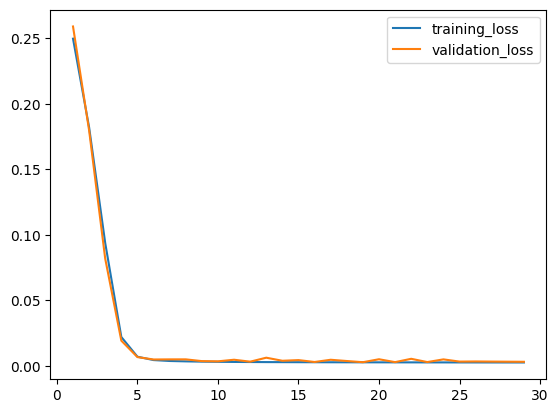

In [11]:
num_iter = len(model.training_losses)
x = np.linspace(1, num_iter, num_iter)
fig = plt.figure()
plt.plot(x, model.training_losses, label="training_loss")
plt.plot(x, model.validation_losses[1:], label="validation_loss")
plt.legend()
plt.show()

##### Best Model Retrieval (EarlyStopping)

In [12]:
print(cp.best_model_path)
print(cp.best_model_score)
model = Autoencoder.load_from_checkpoint(cp.best_model_path)

/LUSTRE/home/ccd/VAE_anomalyHEP/examples/checkpoints/epoch=18-step=855.ckpt
tensor(0.0028)


#### AE: Result Visualization

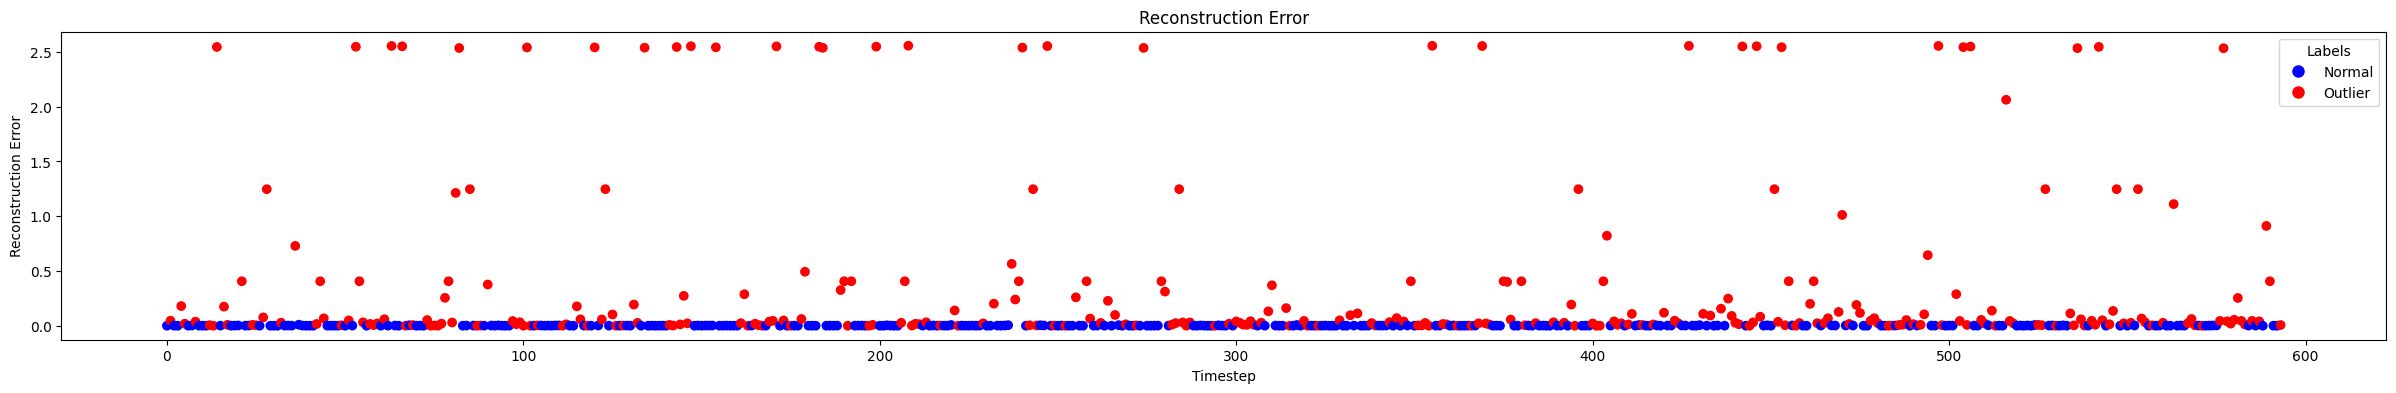

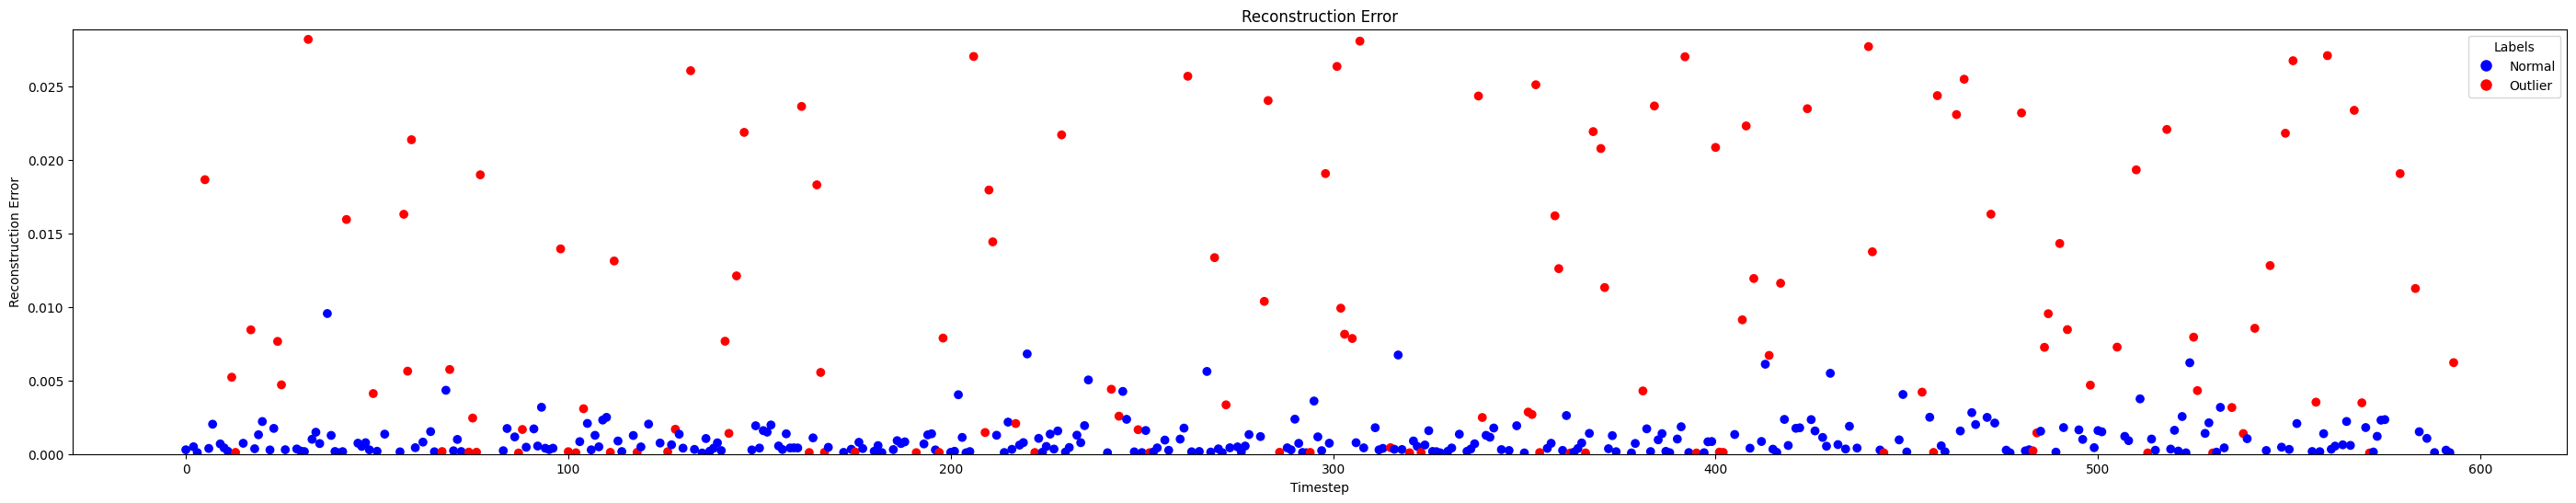

In [14]:
test_ds = SensorDataset(test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=3)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - test) ** 2, axis=1)
except ValueError:  # caused by VAE
    pred = [tup[0] for tup in pred]
    reco = np.mean((np.vstack(pred) - test) ** 2, axis=1)
    
label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in test_label[:, 1]])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]

# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

# Zoomed
plt.figure(figsize=(35, 6))
scatter_zoomed = plt.scatter(range(test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(reco) * 15)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

## Denoising Autoencoder

#### DAE: Pytorch Lightning Model Implementation
Uniformal noise implementation

In [13]:
class DenoisingAutoencoder(L.LightningModule):

    def __init__(self, in_dim, noise_prob: float=0.1):
        super().__init__()
        self.save_hyperparameters()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 8),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, in_dim)
        )

        self.training_losses = []
        self.validation_losses = []

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def training_step(self, batch, batch_idx):
        input = batch
        input_noisy = self.add_noise(input)
        output = self.forward(input_noisy)
        loss = F.mse_loss(output, input)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.training_losses.append(self.trainer.callback_metrics['train_loss'].item())

    def validation_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = F.mse_loss(output, input)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.validation_losses.append(self.trainer.callback_metrics['val_loss'].item())

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        input = batch
        output = self.forward(input)
        return output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def add_noise(self, x):
        mask = torch.rand(x.size()) < self.hparams.noise_prob
        noise = torch.randn(x.size())
        x_noisy = x.clone()
        x_noisy[mask] = noise[mask]
        return x_noisy

#### DAE Model Training

In [14]:
model = DenoisingAutoencoder(in_dim=train.shape[1])
batch_size = 32

dae_train, dae_valid = train_test_split(train, test_size = 0.15, random_state=1, shuffle=True)
dae_train_ds, dae_val_ds = SensorDataset(dae_train), SensorDataset(dae_valid)
dae_tdl, dae_vdl = DataLoader(dae_train_ds, batch_size=batch_size, num_workers=4), DataLoader(dae_val_ds, batch_size=batch_size, num_workers=4)

es = EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00001, patience=10)
cp = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb = SimpleProgressBar()
trainer = L.Trainer(callbacks=[pb, es, cp], max_epochs=1_000, logger=False, enable_checkpointing=True, accelerator="cpu")
trainer.fit(model, train_dataloaders=dae_tdl, val_dataloaders=dae_vdl)

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 2.0 M 
1 | decoder | Sequential | 2.0 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.981    Total estimated model params size (MB)
Epoch 23: 100%|██████████| 45/45 [00:05<00:00,  8.44it/s, loss=0.0037, val_loss=0.0034]


#### DAE: Loss Curve

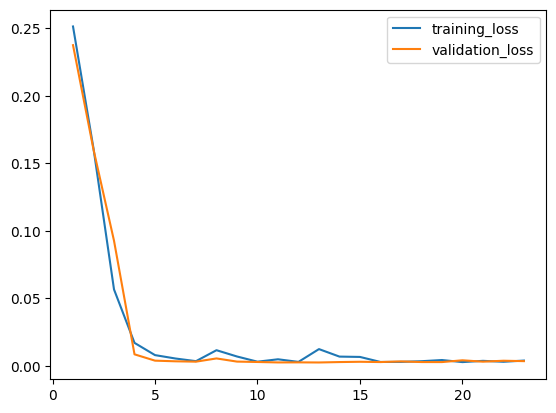

In [15]:
num_iter = len(model.training_losses)
x = np.linspace(1, num_iter, num_iter)
fig = plt.figure()
plt.plot(x, model.training_losses, label="training_loss")
plt.plot(x, model.validation_losses[1:], label="validation_loss")
plt.legend()
plt.show()

##### Best Model Retrieval (EarlyStopping)

In [16]:
print(cp.best_model_path)
print(cp.best_model_score)
model = DenoisingAutoencoder.load_from_checkpoint(cp.best_model_path)

/kaggle/working/checkpoints/epoch=12-step=585.ckpt
tensor(0.0024)


#### DAE: Result Visualization

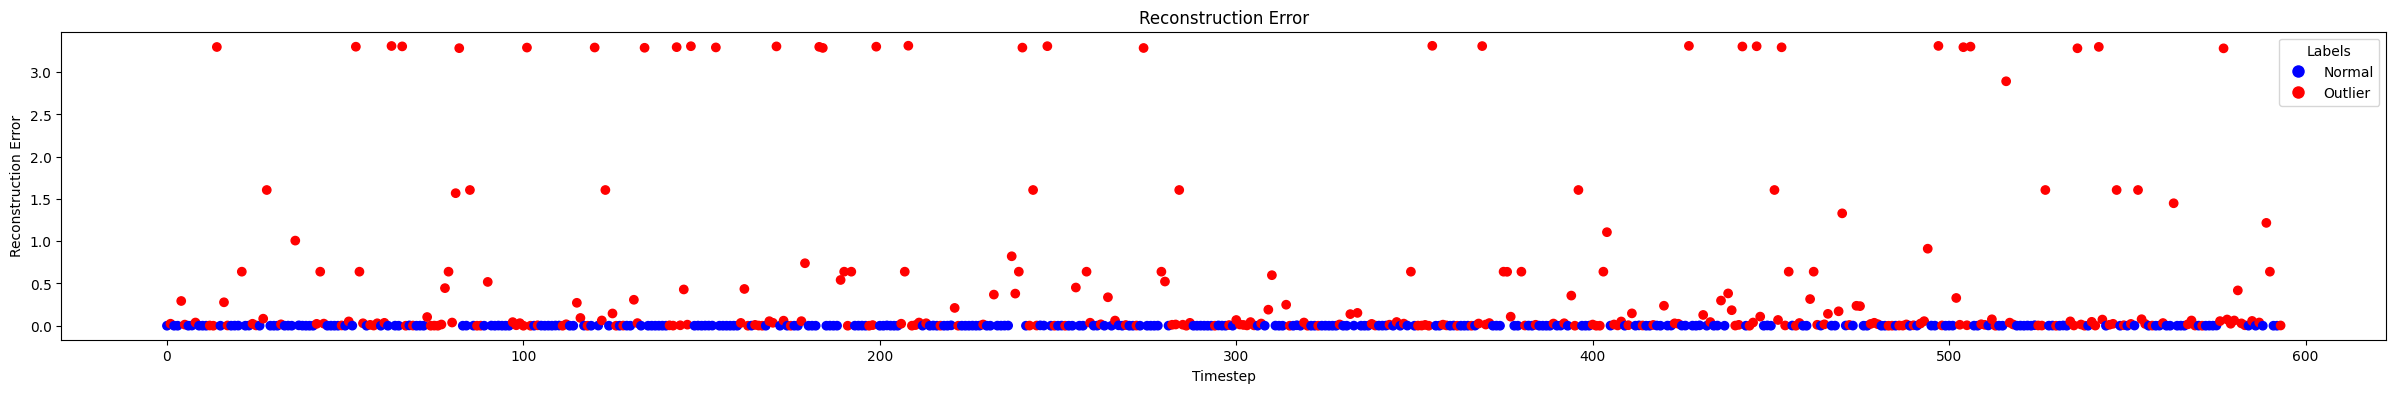

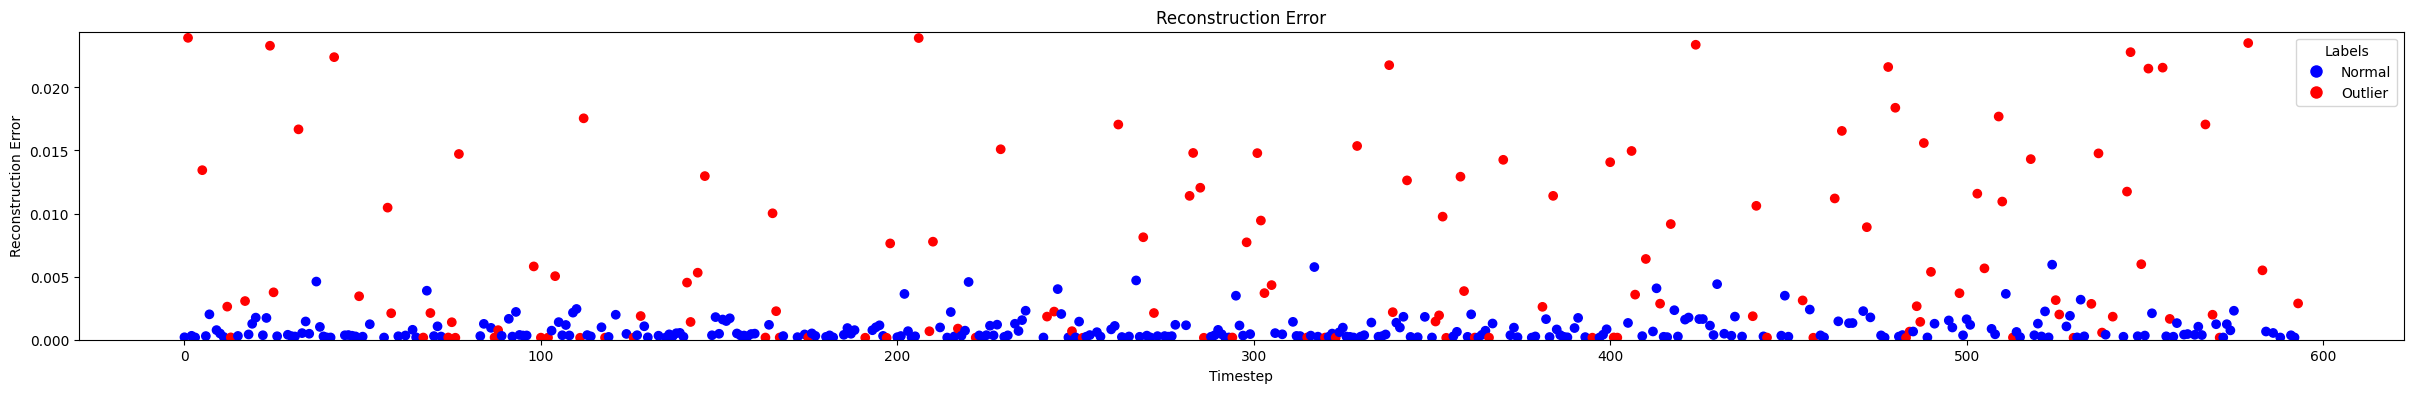

In [17]:
test_ds = SensorDataset(test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=3)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - test) ** 2, axis=1)
except ValueError:  # caused by VAE
    pred = [tup[0] for tup in pred]
    reco = np.mean((np.vstack(pred) - test) ** 2, axis=1)
    
label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in test_label[:, 1]])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]

# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

# Zoomed
plt.figure(figsize=(30, 4))
scatter_zoomed = plt.scatter(range(test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(reco) * 15)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

## β-Variational Autoencoder
#### VAE: Pytorch Lightning Model Implementation
Weight for the Kullback–Leibler divergence of 0.5

In [18]:
class VariationalAutoencoder(L.LightningModule):

    def __init__(self, in_dim):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 8),
        )
        
        self.fc_mu = nn.Linear(8, 8)
        self.fc_var = nn.Linear(8, 8)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, in_dim)
        )

        self.training_losses = []
        self.validation_losses = []

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return mu, log_var

    def decode(self, z):
        result = self.decoder(z)
        return result

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparam(mu, log_var)
        return self.decode(z), input, mu, log_var

    def training_step(self, batch, batch_idx):

        input = batch
        output, _, mu, log_var = self.forward(input)
        loss = self.loss_fn(output, input, mu, log_var)
        self.log('train_loss', loss['loss'], prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.training_losses.append(self.trainer.callback_metrics['train_loss'].item())

    def validation_step(self, batch, batch_idx):

        input = batch
        output, _, mu, log_var = self.forward(input)
        loss = self.loss_fn(output, input, mu, log_var)
        self.log('val_loss', loss['loss'], prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.validation_losses.append(self.trainer.callback_metrics['val_loss'].item())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        input = batch
        return self.forward(input)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def loss_fn(self, *args, **kwargs) -> dict:

        recon = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = 0.5

        recon_loss = F.mse_loss(recon, input)
        kldiv_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recon_loss + kld_weight * kldiv_loss

        return {'loss': loss, 'rec': recon_loss.detach(), 'kld':-kldiv_loss.detach()}

#### VAE Model Training

In [19]:
model = VariationalAutoencoder(in_dim=train.shape[1])
batch_size = 32

vae_train, vae_valid = train_test_split(train, test_size = 0.15, random_state=1, shuffle=True)
vae_train_ds, vae_val_ds = SensorDataset(vae_train), SensorDataset(vae_valid)
vae_tdl, vae_vdl = DataLoader(vae_train_ds, batch_size=batch_size, num_workers=4), DataLoader(vae_val_ds, batch_size=batch_size, num_workers=4)

es = EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00001, patience=10)
cp = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb = SimpleProgressBar()
trainer = L.Trainer(callbacks=[pb, es, cp], max_epochs=1_000, logger=False, enable_checkpointing=True, accelerator="cpu")
trainer.fit(model, train_dataloaders=vae_tdl, val_dataloaders=vae_vdl)

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 2.0 M 
1 | fc_mu   | Linear     | 72    
2 | fc_var  | Linear     | 72    
3 | decoder | Sequential | 2.0 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.982    Total estimated model params size (MB)
Epoch 93: 100%|██████████| 45/45 [00:03<00:00, 11.77it/s, loss=0.0032, val_loss=0.0029]


#### VAE: Loss Curve

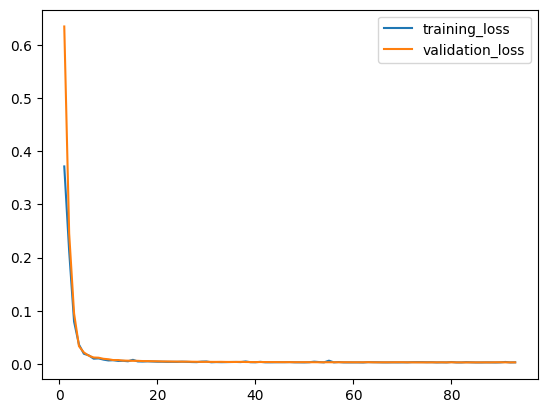

In [20]:
num_iter = len(model.training_losses)
x = np.linspace(1, num_iter, num_iter)
fig = plt.figure()
plt.plot(x, model.training_losses, label="training_loss")
plt.plot(x, model.validation_losses[1:], label="validation_loss")
plt.legend()
plt.show()

##### Best Model Retrieval (EarlyStopping)

In [21]:
print(cp.best_model_path)
print(cp.best_model_score)
model = VariationalAutoencoder.load_from_checkpoint(cp.best_model_path)

/kaggle/working/checkpoints/epoch=82-step=3735.ckpt
tensor(0.0028)


#### VAE: Result Visualization

/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:121: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


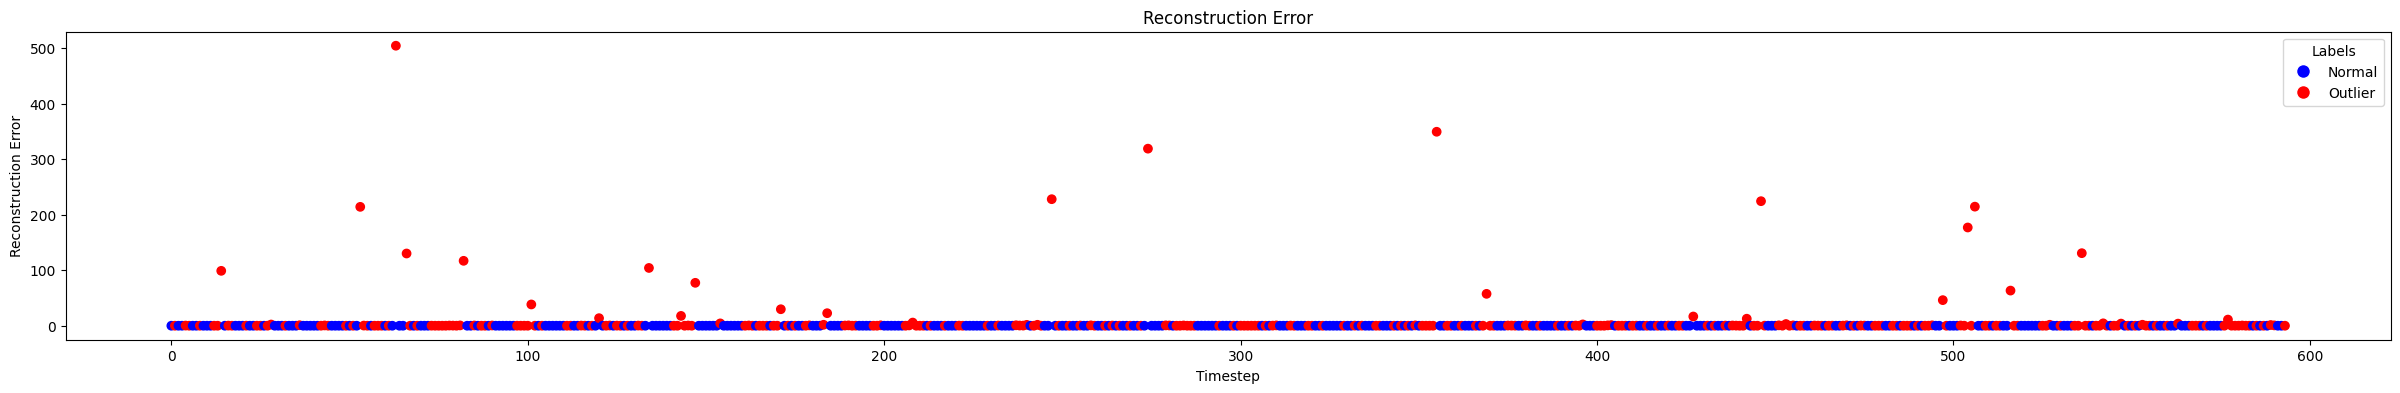

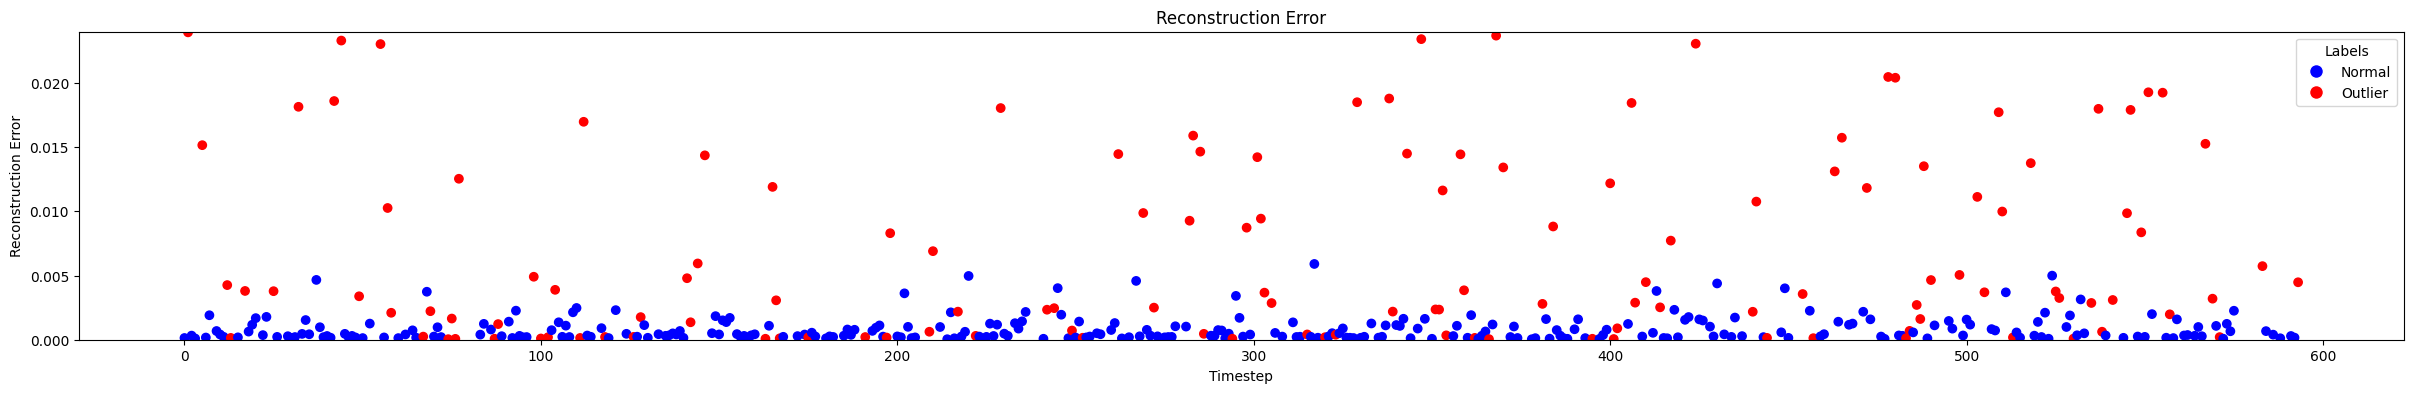

In [22]:
test_ds = SensorDataset(test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=3)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - test) ** 2, axis=1)
except ValueError:  # caused by VAE
    pred = [tup[0] for tup in pred]
    reco = np.mean((np.vstack(pred) - test) ** 2, axis=1)
    
label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in test_label[:, 1]])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]

# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

# Zoomed
plt.figure(figsize=(30, 4))
scatter_zoomed = plt.scatter(range(test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(reco) * 15)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()